# Hidden Markov Model
## 1. Theory

Sources: 
- https://www.scirp.org/journal/paperinformation?paperid=82940#:~:text=For%20stock%20traders%2C%20promptly%20predicting,%E2%80%9D%2C%20or%20%E2%80%9CMedium%E2%80%9D.
- https://www.youtube.com/watch?v=9-sPm4CfcD0

Hidden Markov Models are statistical models that predict observable states using hidden states.

Ex. You have three weather patterns: cloudy, sunny, and rainy. They each have their own unique probabilities and patterns. However, suppose we live in a different city, and we cannot see the weather for ourselves. Instead, we have a friend who lives there. Their mood is influenced by the weather, ie. different probabilities of happy or sad based on the cloudy, rainy, and sunny patterns. 

We compute the joint probability of our friend's mood patterns and their city's weather patterns. Maximizing this joint probability gives us the most likely weather sequence given the observed mood sequence. 

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(X = X_1, X_2, ..., X_n) | Y = Y_1, Y_2, ... Y_n)
$$

This is difficult to find, so we use Bayes' Theorem.
$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(Y | X)P(X) / P(Y)
$$

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} \Pi P(Y_i | X_i)P(X_i|X_{i-1})$$


## 2. Objective
We apply the same concept to predicting stock trends. Our hidden states of prediction are uptrend, downtrend, and flat-trend. Our observable states are the prices, volumes, etc.

In [21]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Fetch and preprocess data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='2m')
    data.columns = data.columns.get_level_values(0)  # Flatten columns
    data['Returns'] = data['Close'].pct_change()
    data['Log Returns'] = np.log(1 + data['Returns'])
    return data.dropna()

# volume, delta of open/close price

# Step 2: Prepare features
def prepare_features(data):
    data['Volatility'] = data['Log Returns'].rolling(window=5).std()
    print(data.columns)
    features = data[['Log Returns', 'Volatility']].dropna().values  # 2D array
    aligned_data = data.dropna(subset=['Log Returns', 'Volatility'])  # Align with features
    return aligned_data, features

# Step 3: Train HMM
def train_hmm(features, n_states):
    print("Training HMM with features shape:", features.shape)  
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(features)
    hidden_states = model.predict(features)
    return model, hidden_states

def plot_hidden_states(data, hidden_states, n_states):
    plt.figure(figsize=(15, 8))
    for state in range(n_states):
        state_data = data[hidden_states == state]
        plt.plot(state_data.index, state_data['Close'], '.', label=f"State {state}")
    plt.title("Stock Price by Hidden States")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

def simulate_trading(data, hidden_states):
    data['State'] = hidden_states
    print(data['State'])
    print(data.eq(0).sum(axis=1))
    data['Signal'] = data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
    print(data['Signal'])
    data['Strategy Returns'] = data['Signal'].shift(1) * data['Returns']
    cumulative_strategy_returns = (1 + data['Strategy Returns'].dropna()).cumprod()
    cumulative_market_returns = (1 + data['Returns'].dropna()).cumprod()
    
    plt.figure(figsize=(15, 8))
    plt.plot(cumulative_strategy_returns, label="Strategy Returns")
    plt.plot(cumulative_market_returns, label="Market Returns")
    plt.legend()
    plt.title("Trading Strategy vs. Market")
    plt.show()
    
def calculate_metrics(data):
    # Define actual price movements (up=1, down=0)
    data['Actual_Movement'] = (data['Returns'] > 0).astype(int)
    
    # Define predicted movements based on states
    data['Predicted_Movement'] = (data['State'] == 0).astype(int)
    
    # Calculate metrics
    true_positives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 1))
    false_positives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 1))
    true_negatives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 0))
    false_negatives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 0))
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(data)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nModel Performance Metrics:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1_score:.3f}")
    
    # Create confusion matrix
    print("\nConfusion Matrix:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log Returns',
       'Volatility'],
      dtype='object', name='Price')
Training HMM with features shape: (775, 2)
Hidden states shape: (775,)

Model Performance Metrics:
Precision: 0.512
Recall: 1.000
Accuracy: 0.512
F1 Score: 0.677

Confusion Matrix:
True Positives: 397
False Positives: 378
True Negatives: 0
False Negatives: 0


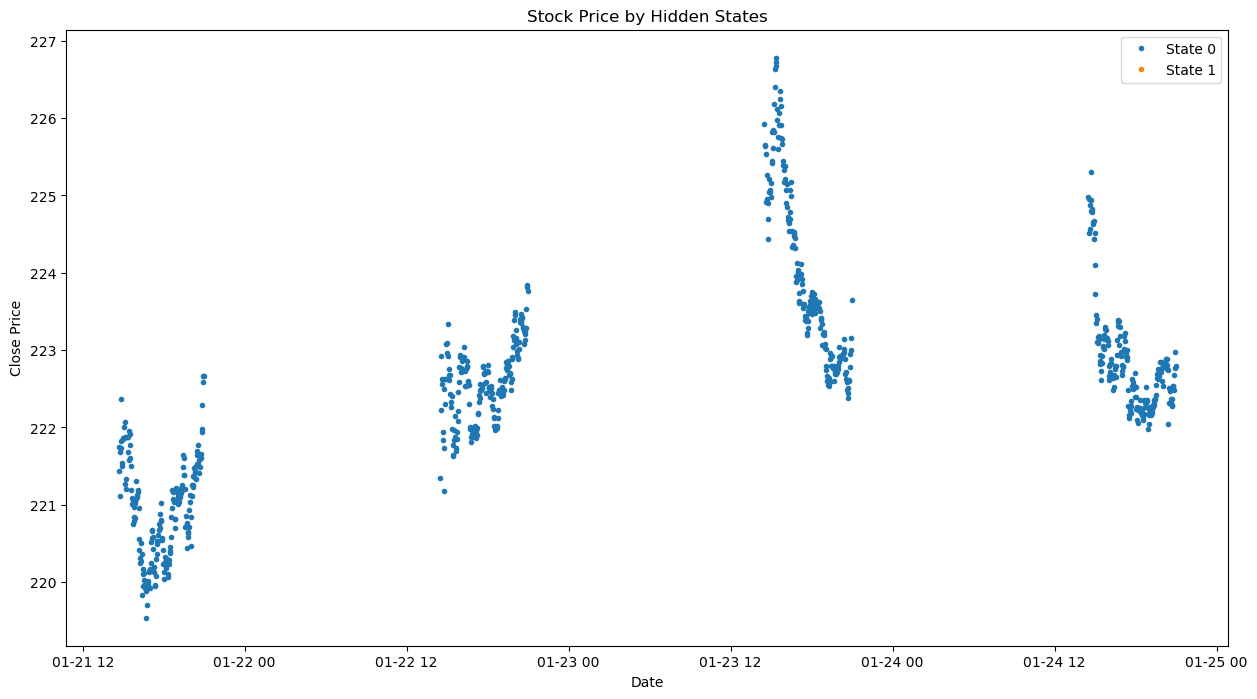

Datetime
2025-01-21 14:40:00+00:00    0
2025-01-21 14:42:00+00:00    0
2025-01-21 14:44:00+00:00    0
2025-01-21 14:46:00+00:00    0
2025-01-21 14:48:00+00:00    0
                            ..
2025-01-24 20:50:00+00:00    0
2025-01-24 20:52:00+00:00    0
2025-01-24 20:54:00+00:00    0
2025-01-24 20:56:00+00:00    0
2025-01-24 20:58:00+00:00    0
Name: State, Length: 775, dtype: int64
Datetime
2025-01-21 14:40:00+00:00    2
2025-01-21 14:42:00+00:00    2
2025-01-21 14:44:00+00:00    2
2025-01-21 14:46:00+00:00    1
2025-01-21 14:48:00+00:00    1
                            ..
2025-01-24 20:50:00+00:00    2
2025-01-24 20:52:00+00:00    1
2025-01-24 20:54:00+00:00    1
2025-01-24 20:56:00+00:00    1
2025-01-24 20:58:00+00:00    2
Length: 775, dtype: int64
Datetime
2025-01-21 14:40:00+00:00    1
2025-01-21 14:42:00+00:00    1
2025-01-21 14:44:00+00:00    1
2025-01-21 14:46:00+00:00    1
2025-01-21 14:48:00+00:00    1
                            ..
2025-01-24 20:50:00+00:00    1
2025-01-2

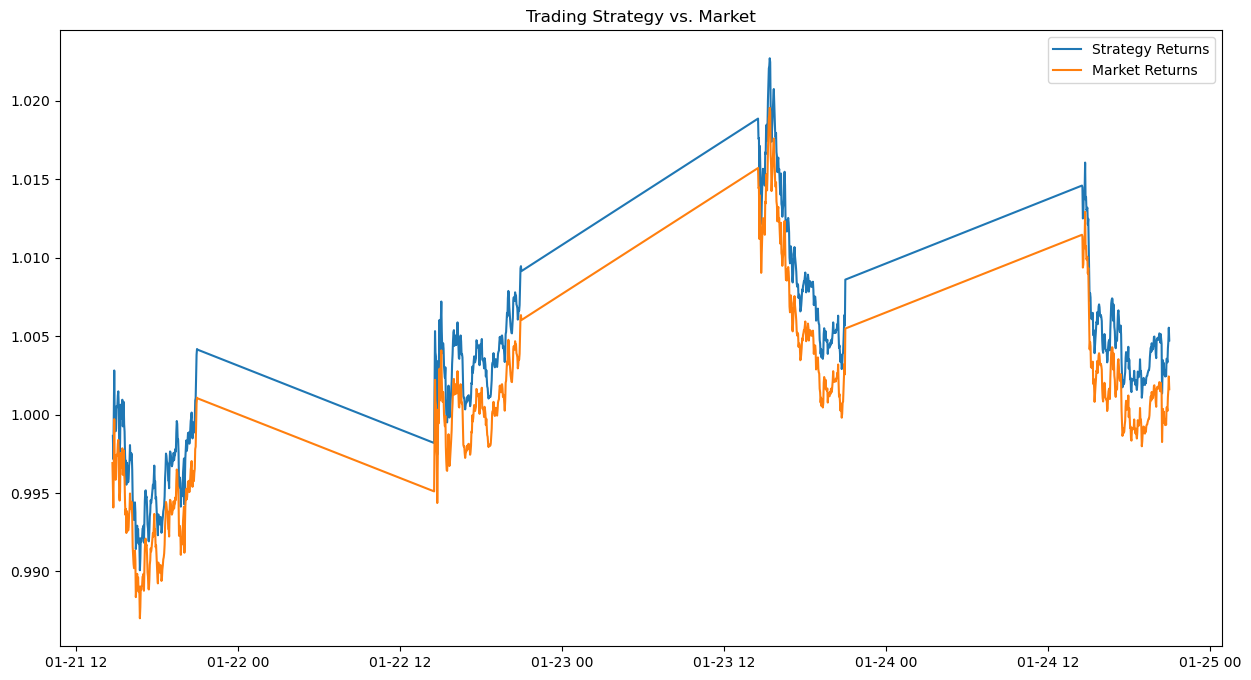

In [22]:
ticker = "AAPL"
from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

# Fetch and preprocess data
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Prepare features
aligned_data, features = prepare_features(stock_data)

# Train HMM
n_states = 2
hmm_model, hidden_states = train_hmm(features, n_states)

print("Hidden states shape:", hidden_states.shape)  # Should be (2259,)
# Plot Hidden States 
aligned_data = aligned_data.copy()  # Ensure it's a standalone DataFrame
aligned_data['State'] = hidden_states
aligned_data['Signal'] = aligned_data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
aligned_data['Strategy Returns'] = aligned_data['Signal'].shift(1) * aligned_data['Returns']
calculate_metrics(aligned_data)
plot_hidden_states(aligned_data, hidden_states, n_states)

# Simulate Trading Strategy 
simulate_trading(aligned_data, hidden_states)
